In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
gc.collect()
torch.cuda.empty_cache()

True
NVIDIA GeForce RTX 4060


Train fields: (421, 192, 192, 1), masks: (421, 192, 192, 1)
Val fields: (90, 192, 192, 1), masks: (90, 192, 192, 1)
Test fields: (91, 192, 192, 1), masks: (91, 192, 192, 1)


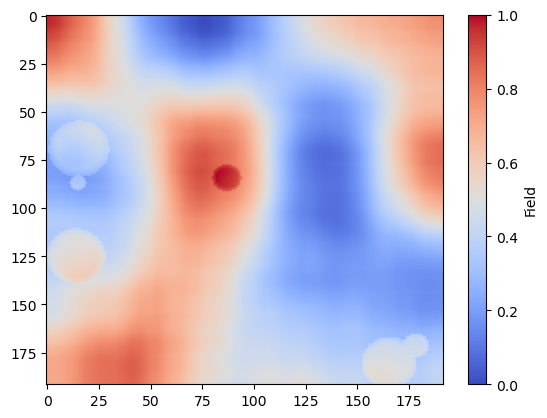

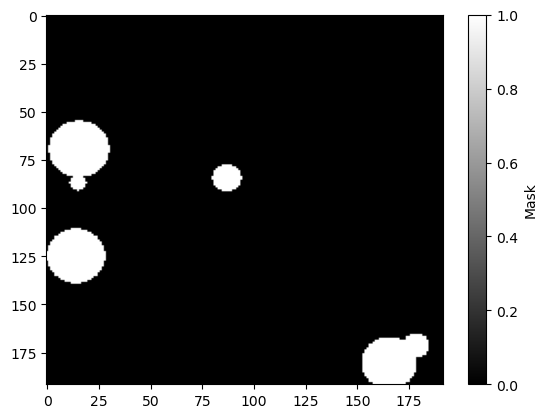

In [5]:
""" Data import"""
field = np.load('../data/field600.npy') # Replace to name of field array, created with notebook "1_Traing_array_creation.ipynb"
mask = np.load('../data/mask600.npy') # Replace to name of mask array, created with notebook "1_Traing_array_creation.ipynb"

#Augmentation
"""fields_rotated = np.rot90(field, k=1, axes=(1, 2))
masks_rotated = np.rot90(mask, k=1, axes=(1, 2))

field = np.concatenate([field, fields_rotated], axis=0)
mask = np.concatenate([mask, masks_rotated], axis=0)"""

# Train, test, validation split
train_field, temp_field, train_mask, temp_mask = train_test_split(field, mask, test_size=0.3, random_state=42)
val_field, test_field, val_mask, test_mask = train_test_split(temp_field, temp_mask, test_size=0.5, random_state=42)

# Size of data
print(f"Train fields: {train_field.shape}, masks: {train_mask.shape}") 
print(f"Val fields: {val_field.shape}, masks: {val_mask.shape}")        
print(f"Test fields: {test_field.shape}, masks: {test_mask.shape}")     

plt.imshow(train_field[5], aspect='auto', cmap='coolwarm')
plt.colorbar(label='Field') 
plt.show()
plt.imshow(train_mask[5], aspect='auto', cmap='gray')
plt.colorbar(label='Mask') 
plt.show()

In [7]:
# Batch Size
batch_size = 64

In [9]:
# Loss functions and metrics
def jaccard_loss(y_true, y_pred, smooth=1.):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return 1. - (intersection + smooth) / (union + smooth)

def iou_metric(y_true, y_pred, smooth=1.):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def combined_loss(outputs, targets, alpha = 0.85): # Here you can change 'alpha' coefficient between BCE and JaccardLoss
    bce = F.binary_cross_entropy(outputs, targets)
    iou = jaccard_loss(outputs, targets)
    return alpha * bce + (1 - alpha) * iou

In [11]:
"""Class of field and mask data"""
class FieldMaskDataset(Dataset):
    def __init__(self, fields, masks, transform=None):
        self.fields = fields
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.fields)

    def __getitem__(self, idx):
        fields = self.fields[idx]           
        mask = self.masks[idx]              

        # Transpose HWC → CHW
        if fields.ndim == 2:
           fields = np.expand_dims(fields, axis=-1)  # (H, W) → (H, W, 1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        fields = fields.transpose(2, 0, 1)     
        mask = mask.transpose(2, 0, 1)       

        # Convert to float32
        fields = torch.tensor(fields, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return fields, mask

# DataLoader
train_dataset = FieldMaskDataset(train_field, train_mask)
val_dataset = FieldMaskDataset(val_field, val_mask)
test_dataset = FieldMaskDataset(test_field, test_mask)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

field_tr, mask_tr = next(iter(train_loader))
print(field_tr.shape)
print(mask_tr.shape)

torch.Size([64, 1, 192, 192])
torch.Size([64, 1, 192, 192])


In [13]:
"""Model U-Net with "encoder_name" backbone"""
model = smp.Unet(
    encoder_name="timm-efficientnet-b2",  # Here you can change backbone
    encoder_weights="imagenet",      
    in_channels=1,                  
    classes=1,                       
    activation='sigmoid',
    encoder_depth = 5,                  
    encoder_channels=[64, 128, 256, 512, 1024]
)

# Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)

Device: cuda


Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), 

In [15]:
"""Trains a PyTorch model with validation and model checkpointing.
    
    Args:
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        device (torch.device): Device to train on ('cuda' or 'cpu').
        epochs (int, optional): Number of training epochs. Defaults to 20.
        loss_fn (callable, optional): Loss function. If None, uses combined_loss. Defaults to None.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. 
            Defaults to None.
        save_path (str, optional): Path to save the best model weights. Defaults to 'best_model.pth'.
    
    Returns:
        None: The function doesn't return anything but saves the best model weights to disk.
    
    Note:
        - Uses IoU (Intersection over Union) as the validation metric.
        - Saves model when validation IoU improves.
        - Applies threshold of 0.5 to binarize model outputs for IoU calculation.
        - Prints training and validation metrics after each epoch."""


def train_model(model, train_loader, val_loader, optimizer,
    device, epochs=20, loss_fn=None, scheduler=None, save_path='best_model.pth'):
    model.to(device)

    if loss_fn is None:
        loss_fn=combined_loss

    best_val_iou = 0.0 

    for epoch in range(epochs):
        model.train()
        train_loss, train_iou = 0.0, 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            outputs = (outputs > 0.5).float()  # binarization of predictions by threshold 0.5
            iou = iou_metric(masks, outputs)

            train_loss += loss.item()
            train_iou += iou.item()

        model.eval()
        val_loss, val_iou = 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                
                loss = loss_fn(outputs, masks)
                outputs = (outputs > 0.5).float()  # binarization of predictions by threshold 0.5
                iou = iou_metric(masks, outputs)

                val_loss += loss.item()
                val_iou += iou.item()
    
        avg_val_iou = val_iou / len(val_loader)
        
        # Save best model
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with Val IoU: {best_val_iou:.4f}")
        
        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train IoU: {train_iou/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val IoU: {val_iou/len(val_loader):.4f}")

In [17]:
"""Model train"""
m_epochs = 30
optimizer = Adam(model.parameters(), lr=0.0001)

train_model(model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, device=device,
            epochs=m_epochs, loss_fn=combined_loss)

Epoch 1/30 - Train: 100%|██████████| 7/7 [01:08<00:00,  9.75s/it]


New best model saved with Val IoU: 0.0870
Epoch 1: Train Loss: 0.6359, Train IoU: 0.0613 | Val Loss: 0.6831, Val IoU: 0.0870


Epoch 2/30 - Train: 100%|██████████| 7/7 [01:02<00:00,  8.92s/it]


New best model saved with Val IoU: 0.1282
Epoch 2: Train Loss: 0.5681, Train IoU: 0.1639 | Val Loss: 0.6479, Val IoU: 0.1282


Epoch 3/30 - Train: 100%|██████████| 7/7 [01:00<00:00,  8.70s/it]


New best model saved with Val IoU: 0.2349
Epoch 3: Train Loss: 0.5150, Train IoU: 0.3057 | Val Loss: 0.6063, Val IoU: 0.2349


Epoch 4/30 - Train: 100%|██████████| 7/7 [01:01<00:00,  8.77s/it]


New best model saved with Val IoU: 0.3337
Epoch 4: Train Loss: 0.4682, Train IoU: 0.4362 | Val Loss: 0.5419, Val IoU: 0.3337


Epoch 5/30 - Train: 100%|██████████| 7/7 [01:00<00:00,  8.64s/it]


New best model saved with Val IoU: 0.4496
Epoch 5: Train Loss: 0.4296, Train IoU: 0.5491 | Val Loss: 0.4820, Val IoU: 0.4496


Epoch 6/30 - Train: 100%|██████████| 7/7 [01:00<00:00,  8.64s/it]


New best model saved with Val IoU: 0.5394
Epoch 6: Train Loss: 0.3992, Train IoU: 0.6416 | Val Loss: 0.4329, Val IoU: 0.5394


Epoch 7/30 - Train: 100%|██████████| 7/7 [01:00<00:00,  8.65s/it]


New best model saved with Val IoU: 0.6298
Epoch 7: Train Loss: 0.3759, Train IoU: 0.7098 | Val Loss: 0.3941, Val IoU: 0.6298


Epoch 8/30 - Train: 100%|██████████| 7/7 [00:59<00:00,  8.52s/it]


New best model saved with Val IoU: 0.7090
Epoch 8: Train Loss: 0.3570, Train IoU: 0.7563 | Val Loss: 0.3673, Val IoU: 0.7090


Epoch 9/30 - Train: 100%|██████████| 7/7 [00:59<00:00,  8.52s/it]


New best model saved with Val IoU: 0.7581
Epoch 9: Train Loss: 0.3410, Train IoU: 0.7856 | Val Loss: 0.3480, Val IoU: 0.7581


Epoch 10/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.7949
Epoch 10: Train Loss: 0.3274, Train IoU: 0.8056 | Val Loss: 0.3320, Val IoU: 0.7949


Epoch 11/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.8217
Epoch 11: Train Loss: 0.3155, Train IoU: 0.8244 | Val Loss: 0.3185, Val IoU: 0.8217


Epoch 12/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.8408
Epoch 12: Train Loss: 0.3050, Train IoU: 0.8422 | Val Loss: 0.3067, Val IoU: 0.8408


Epoch 13/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.8528
Epoch 13: Train Loss: 0.2956, Train IoU: 0.8579 | Val Loss: 0.2958, Val IoU: 0.8528


Epoch 14/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.37s/it]


New best model saved with Val IoU: 0.8637
Epoch 14: Train Loss: 0.2872, Train IoU: 0.8681 | Val Loss: 0.2853, Val IoU: 0.8637


Epoch 15/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.8736
Epoch 15: Train Loss: 0.2795, Train IoU: 0.8780 | Val Loss: 0.2763, Val IoU: 0.8736


Epoch 16/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.8840
Epoch 16: Train Loss: 0.2725, Train IoU: 0.8858 | Val Loss: 0.2686, Val IoU: 0.8840


Epoch 17/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.8911
Epoch 17: Train Loss: 0.2658, Train IoU: 0.8923 | Val Loss: 0.2616, Val IoU: 0.8911


Epoch 18/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.37s/it]


New best model saved with Val IoU: 0.8975
Epoch 18: Train Loss: 0.2595, Train IoU: 0.8968 | Val Loss: 0.2556, Val IoU: 0.8975


Epoch 19/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.35s/it]


New best model saved with Val IoU: 0.9008
Epoch 19: Train Loss: 0.2536, Train IoU: 0.9012 | Val Loss: 0.2500, Val IoU: 0.9008


Epoch 20/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.9097
Epoch 20: Train Loss: 0.2480, Train IoU: 0.9051 | Val Loss: 0.2446, Val IoU: 0.9097


Epoch 21/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


Epoch 21: Train Loss: 0.2427, Train IoU: 0.9094 | Val Loss: 0.2398, Val IoU: 0.9093


Epoch 22/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.9173
Epoch 22: Train Loss: 0.2376, Train IoU: 0.9114 | Val Loss: 0.2350, Val IoU: 0.9173


Epoch 23/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.9183
Epoch 23: Train Loss: 0.2328, Train IoU: 0.9161 | Val Loss: 0.2304, Val IoU: 0.9183


Epoch 24/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.9214
Epoch 24: Train Loss: 0.2281, Train IoU: 0.9183 | Val Loss: 0.2260, Val IoU: 0.9214


Epoch 25/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.9224
Epoch 25: Train Loss: 0.2237, Train IoU: 0.9217 | Val Loss: 0.2218, Val IoU: 0.9224


Epoch 26/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.9250
Epoch 26: Train Loss: 0.2194, Train IoU: 0.9234 | Val Loss: 0.2177, Val IoU: 0.9250


Epoch 27/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.35s/it]


New best model saved with Val IoU: 0.9271
Epoch 27: Train Loss: 0.2152, Train IoU: 0.9261 | Val Loss: 0.2138, Val IoU: 0.9271


Epoch 28/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.37s/it]


New best model saved with Val IoU: 0.9277
Epoch 28: Train Loss: 0.2112, Train IoU: 0.9281 | Val Loss: 0.2102, Val IoU: 0.9277


Epoch 29/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.35s/it]


New best model saved with Val IoU: 0.9300
Epoch 29: Train Loss: 0.2073, Train IoU: 0.9299 | Val Loss: 0.2064, Val IoU: 0.9300


Epoch 30/30 - Train: 100%|██████████| 7/7 [00:58<00:00,  8.36s/it]


New best model saved with Val IoU: 0.9330
Epoch 30: Train Loss: 0.2035, Train IoU: 0.9320 | Val Loss: 0.2028, Val IoU: 0.9330


torch.Size([1, 1, 192, 192])


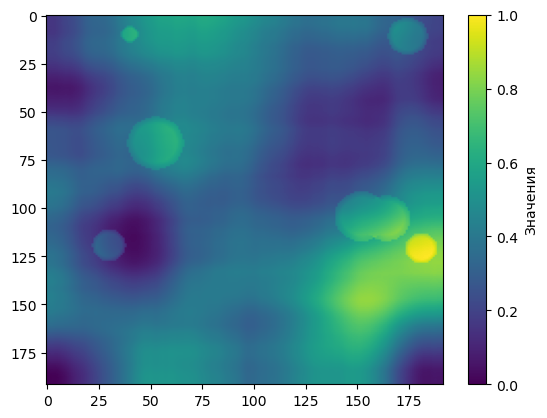

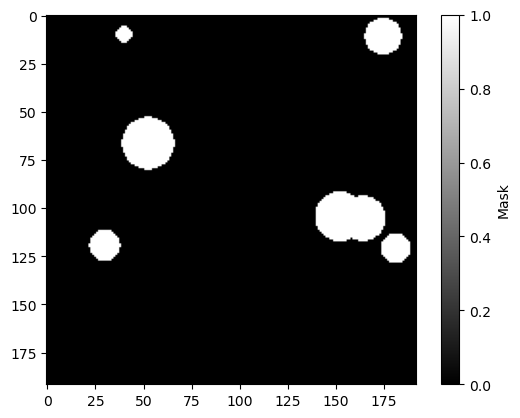

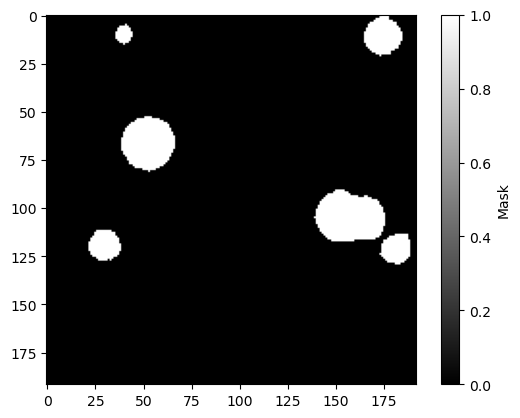

In [18]:
# Random example of test dataset
idx = np.random.randint(0, len(test_dataset))
field, true_mask = train_dataset[idx]

model_best = model

model_best.load_state_dict(torch.load('best_model.pth'))
model_best.to(device)
model_best.eval()

field = field.unsqueeze(0).to(device)
print(field.shape)

with torch.no_grad():
    pred_mask = model_best(field).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5)

plt.imshow(field.squeeze().cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Field') 
plt.show()
plt.imshow (true_mask.squeeze(), cmap='gray')
plt.colorbar(label='Mask') 
plt.show()
plt.imshow (pred_mask.squeeze(), cmap='gray')
plt.colorbar(label='Mask') 
plt.show()

In [19]:
# Accuracy evaluation on the test set
# IoU metric
def evaluate_model(model, test_loader, device):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            preds = (outputs > 0.5).float()  # Binarization
            for i in range(targets.size(0)):
                y_true = targets[i].cpu()
                y_pred = preds[i].cpu()
                iou = iou_metric(y_true, y_pred)
                iou_scores.append(iou.item())

    mean_iou = sum(iou_scores) / len(iou_scores)
    print(len(iou_scores))
    return mean_iou

test_iou = evaluate_model(model_best, test_loader, device)

print(f"Mean IoU on test set: {test_iou:.4f}")

91
Mean IoU on test set: 0.9329


In [20]:
"""Save model"""
torch.save(model_best, '../weights/model_600_Unet_EffNetb2-ВСЕ0p85_192.pth')